# Tracing Transformations

In can be sometimes difficult to remember all the transformations that you apply to your data in the course of your work. Quite often , this results in reported protocols that do not match the actual steps taken during an analysis, so published results may not be readily reproduced. We illustrate this using the example of `L2_spectral_analysis.ipynb` (TODO: link to notebook from here):

In [32]:
%load_ext autoreload
%autoreload 2
import pyleoclim as pyleo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's first import the data into a Pandas DataFrame from which we can create our [`Series` object](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#series-pyleoclim-series):

In [2]:
df = pd.read_csv('../data/LR04.csv',skiprows=4)
df.head()

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03


In [3]:
lr04 = pyleo.Series(time=df.iloc[:,0],value=df.iloc[:,1],value_name='Benthic $\delta^{18}O$',value_unit=u'\u2030',
                   time_name='Age',time_unit='ky BP',label='LR04')

In `L2_spectral_analysis.ipynb`, we plot this iconic compilation by inverting the y axis:

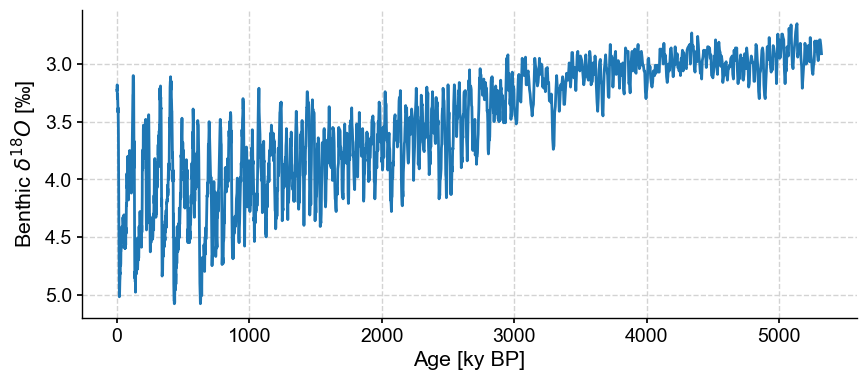

In [4]:
fig, ax = lr04.plot(legend=False, invert_yaxis=True) 

Let's work with the first 3 million years (3000 kyr) of the record for illustrative purposes:

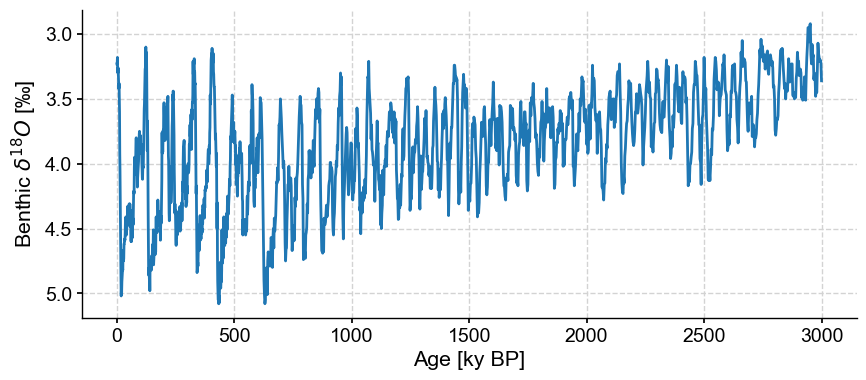

In [5]:
lr04_s = lr04.slice([0,3000])
fig,ax = lr04_s.plot(legend=False, invert_yaxis=True) 

In `L2_spectral_analysis.ipynb`, we applied 3 transformations to the data prior to conducting spectral analysis: __detrending__, __interpolation__ (each with default value), and __standardization__. If we ask to keep a log of such transformations at each turn, the resulting Series object will contain a field called `log`, which can be mined for information:

In [7]:
lr04_seq = lr04_s.detrend(keep_log=True).interp(keep_log=True).standardize(keep_log=True)

In [8]:
lr04_seq.log

({0: 'clean_ts', 'applied': True, 'verbose': False},
 {1: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([4.11436493, 4.11437622, 4.11438901, ..., 3.62013935, 3.62016692,
         3.62019564])},
 {2: 'interp', 'method': 'linear', 'args': {}},
 {3: 'standardize',
  'args': 1,
  'previous_mean': -0.03976659292079166,
  'previous_std': 0.3316881380725932})

This log is a [tuple](https://www.dataquest.io/blog/python-tuples/) of [dictionaries](https://www.dataquest.io/blog/data-structures-in-python/), a very flexible (and immutable) data structures that ensures that many fields can be traced, in an order that cannot be touched. This log reveals several things:
- the series was [cleaned](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsbase.clean_ts) upon creation, as is the [default](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsbase.clean_ts). 
- the series was then detrended, and we see here that it was done using empirical mode decomposition (see [here](https://pyleoclim-util.readthedocs.io/en/master/utils/introduction.html#pyleoclim.utils.tsutils.detrend) for details. The original trend is kept here as an array in case you need to use it later (e.g. put it back). 
- the `Series` was then interpolated using linear interpolation with default parameters.
- then it was standardized, and the log kept the mean and standard deviation in case they are needed later. 

If you wanted to access the original trend, you would go for the second index of this tuple, and use the dictionary key 'previous_trend':

In [12]:
lr04_seq.log[1]['previous_trend']

array([4.11436493, 4.11437622, 4.11438901, ..., 3.62013935, 3.62016692,
       3.62019564])

This can be plotted along side the original series:

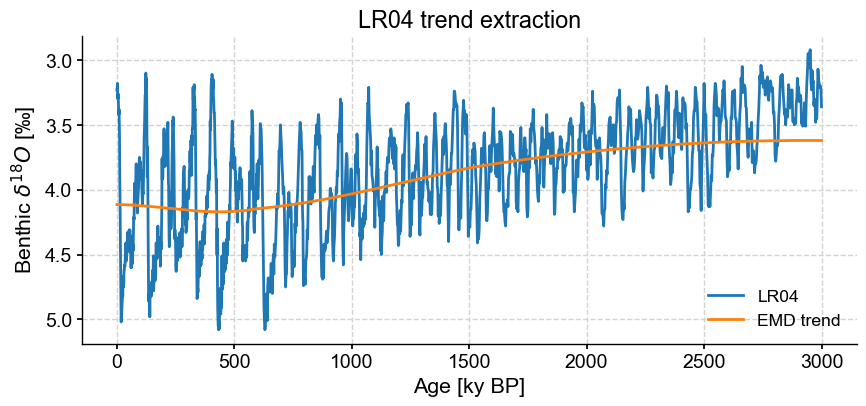

In [11]:
fig, ax = lr04_s.plot(title='LR04 trend extraction', invert_yaxis=True)
ax.plot(lr04_s.time,lr04_seq.log[1]['previous_trend'],label='EMD trend')
ax.legend(); 

So far we have worked with the original, but flipped the plots. We may instead wish to flip the values themselves:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='Benthic $\\delta^{18}O$ x (-1) [‰]'>)

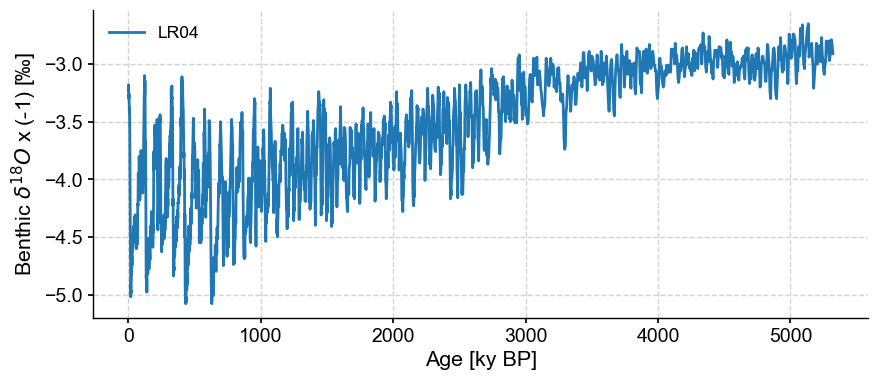

In [42]:
lr04_f = lr04.flip(axis='value', keep_log=True)
lr04_f.plot()

Note that the label has been updated to reflect the flip. If we now apply the same sequence of transformations as before, this will be reflected in the log:

In [48]:
lr04_fseq = lr04_f.detrend(keep_log=True).interp(keep_log=True).standardize(keep_log=True)
lr04_fseq.log

({0: 'clean_ts', 'applied': True, 'verbose': False},
 {1: 'flip', 'applied': True, 'axis': 'value'},
 {2: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([-4.11361122, -4.11359379, -4.11357686, ..., -2.92825926,
         -2.92825817, -2.92826008])},
 {3: 'interp', 'method': 'linear', 'args': {}},
 {4: 'standardize',
  'args': 1,
  'previous_mean': 0.00035043272519027753,
  'previous_std': 0.2533686838369521})

The Seris can be flipped back, but an error message will be issued to warn users that flipping was previously applied:

In [49]:
lr04_ff = lr04_fseq.flip(keep_log=True)

/Users/julieneg/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:415: UserWarning: this Series' log indicates that it has previously been flipped
  warnings.warn("this Series' log indicates that it has previously been flipped")


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='Benthic $\\delta^{18}O$ x (-1) x (-1) [‰]'>)

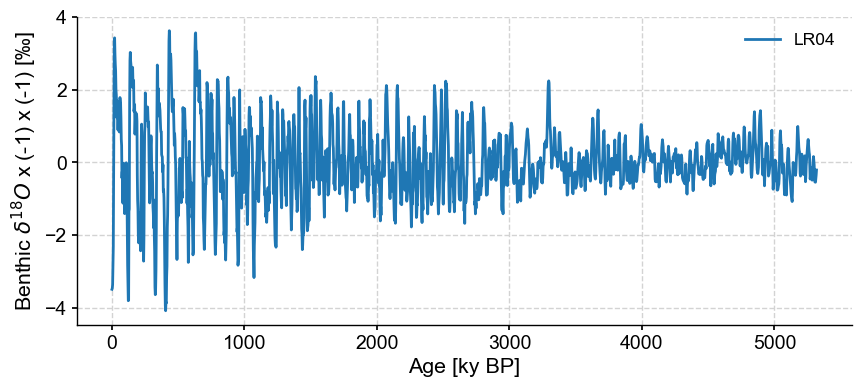

In [50]:
lr04_ff.plot()

In this case, one might want to clean up the `value_name` property, by copying the original one:

In [46]:
lr04_ff.value_name = lr04.value_name

Finally, the log will reflect this double-flipping as well:

In [51]:
lr04_ff.log

({0: 'clean_ts', 'applied': True, 'verbose': False},
 {1: 'flip', 'applied': True, 'axis': 'value'},
 {2: 'detrend',
  'method': 'emd',
  'args': {},
  'previous_trend': array([-4.11361122, -4.11359379, -4.11357686, ..., -2.92825926,
         -2.92825817, -2.92826008])},
 {3: 'interp', 'method': 'linear', 'args': {}},
 {4: 'standardize',
  'args': 1,
  'previous_mean': 0.00035043272519027753,
  'previous_std': 0.2533686838369521},
 {5: 'flip', 'applied': True, 'axis': 'value'})